# Prova 2 - NLP - 2025s1

INSTRUÇÕES: Resolva esta prova. Após, transcreva as partes dissertativas das respostas para o Blackboard (CTRL-C / CTRL-V) nos espaços indicados. Por fim, anexe seu notebook como material complementar da Questão 2.

## Rubrica geral da prova

Níveis de aprendizado

* 0 [F] Insuficiente: Falha em atingir todos os requisitos do nível seguinte.
* 2.5 [D] Em desenvolvimento: Identifica o sub-domínio ou a categoria de ferramentas que podem levar a soluções de problemas. Identifica quais são as entradas e saídas de um sistema, e seu significado para o problema. É capaz de resolver problemas usando códigos "template".
* 5.0 [C] Básico: É capaz de argumentar a favor ou contra uma solução usando jargões técnicos, com uso mínimo de metáforas. Usa corretamente métricas de desempenho para avaliar soluções. É capaz de modificar parâmetros de sistema para adequá-los a uma situação específica e avaliar o efeito dessas modificações.
* 7.5 [B] Proficiente: Identifica, usando método científico, os componentes do sistema que levam a gargalos de desempenho. Argumenta corretamente e usando os jargões adequados sobre as limitações das métricas de desempenho, e argumenta sobre o impacto dessas limitações para o problema específico. Cita brevemente formulações matemáticas. Justifica suas principais escolhas com argumentos precisos e/ou com resultados de análises.
* 10 [A] Avançado: Argumenta sobre soluções e sobre suas limitações usando jargões técnicos precisos. Liga claramente os parâmetros do mundo real aos parâmetros matemáticos das formulações. Justifica todas as suas escolhas com argumentos precisos e/ou com resultados de análises.

## Problema

É relativamente comum usarmos embeddings gerados pelo BERT para classificar frases. Em geral, o código para gerar embeddings com BERT se parece com:
```python
    from transformers import BertTokenizer, BertModel
    from tqdm import tqdm
    import numpy as np
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model = BertModel.from_pretrained('bert-base-uncased')
    def get_embeddings(text, model, tokenizer):
        # Tokenize the input text
        inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=512)
        outputs = model(**inputs)
        cls_embedding = outputs.last_hidden_state[0, 0, :]
        return cls_embedding

    embeddings = []
    for i in tqdm(range(len(X))):
        e = get_embeddings(X.iloc[i], model, tokenizer)
        embeddings.append(e.detach().numpy())
    embeddings = np.array(embeddings)
    np.save('bert_embeddings.npy', embeddings)
```
De acordo com o [artigo do BERT](https://arxiv.org/abs/1810.04805), os embeddings foram treinados, usando um token por palavra, em diversos textos em inglês:

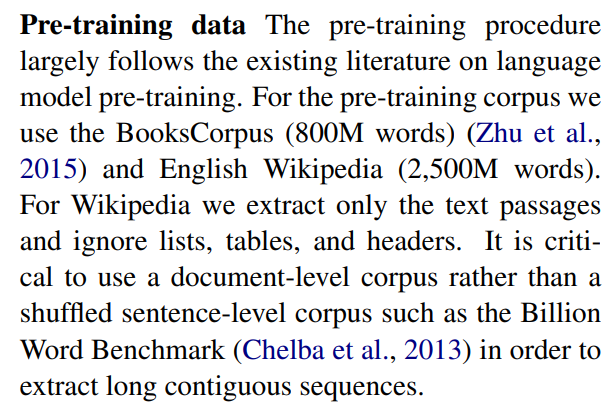

Porém, em lugares que não temos a língua inglesa como língua padrão, gostaríamos de realizar tarefas de classificação em línguas nativas.

Neste trabalho, vamos trabalhar com a classificação de mensagens no twitter sobre o Ibovespa. A ideia de fazer essa classificação é que o Twitter poderia ser uma representação do sentimento geral do mercado (*bullish* ou *bearish* markets). O dataset para isso é o seguinte:

In [1]:
import kagglehub
from pathlib import Path
import pandas as pd

# Download latest version
path = kagglehub.dataset_download("jvbeltra/sentiment-analysis-pt-br-stock-market-tweets")
path = Path(path)
df = pd.read_csv(path / "analise_sentimentos_ibovespa_twitter.csv")
df.head()

100%|██████████| 92.7k/92.7k [00:00<00:00, 438kB/s]

Extracting files...


,post_id,text,created_at,finbertptbr_prediction,gpt_prediction,real_sentiment
0,1818246570069934451,"a partir desse cálculo, para cada empresa do i...",2024-07-30T08:25:38.000000Z,NEUTRAL,NEUTRAL,NEUTRAL
1,1818251106570395982,ibovespa reage às entrelinhas do relatório de ...,2024-07-30T08:43:39.000000Z,NEUTRAL,NEUTRAL,NEUTRAL
2,1818257465793765640,ibovespa em queda de olho na reunião do copom,2024-07-30T09:08:56.000000Z,NEGATIVE,NEGATIVE,NEGATIVE
3,1818262436144669087,esquenta dos mercados \nbom dia!\no ibovespa a...,2024-07-30T09:28:41.000000Z,POSITIVE,NEUTRAL,NEUTRAL
4,1818262819063660642,ibovespa futuro cai na expectativa pelo 1º dia...,2024-07-30T09:30:12.000000Z,NEGATIVE,NEGATIVE,NEGATIVE


Como podemos ver, a tarefa é relacionar o conteúdo da coluna "text" ao rótulo colocado em "real_sentiment". Este dataset em especial já traz predições realizadas por outros modelos (finBertPt e GPT 3.5), que foram usadas em trabalhos anteriores. Ignore essas informações pois não vamos usá-las.

Para extrair embeddings de todos os textos do dataset, podemos usar o seguinte laço:

In [2]:
from transformers import BertTokenizer, BertModel
from tqdm import tqdm
import numpy as np
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')
def get_embeddings(text, model, tokenizer):
    # Tokenize the input text
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=512)
    outputs = model(**inputs)
    cls_embedding = outputs.last_hidden_state[0, 0, :]
    return cls_embedding

embeddings = []
for i in tqdm(range(len(df))):
    e = get_embeddings(df.iloc[i]['text'], model, tokenizer)
    embeddings.append(e.detach().numpy())
embeddings = np.array(embeddings)
np.save('bert_embeddings.npy', embeddings)

100%|██████████| 1290/1290 [00:55<00:00, 23.10it/s]


Porém, BERT foi treinado em inglês, e, portanto, talvez haja problemas com o vocabulário em português. Para evitar isso é possível usar a versão multilingual de BERT, que foi treinada em dumps da Wikipedia em várias línguas:

In [3]:
tokenizer_pt = BertTokenizer.from_pretrained('bert-base-multilingual-uncased')
model_pt = BertModel.from_pretrained("bert-base-multilingual-uncased")
embeddings = []
for i in tqdm(range(len(df))):
    e = get_embeddings(df.iloc[i]['text'], model_pt, tokenizer_pt)
    embeddings.append(e.detach().numpy())
embeddings = np.array(embeddings)
np.save('bert_pt_embeddings.npy', embeddings)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.72M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/672M [00:00<?, ?B/s]

100%|██████████| 1290/1290 [00:50<00:00, 25.46it/s]


Por fim, temos sempre nossa hipótese nula: a de que um sistema com Bag of Words funciona bem o suficiente para nossa tarefa:

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(df['text'], df['real_sentiment'], test_size=0.2, random_state=42)

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression(max_iter=1000))
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    NEGATIVE       0.77      0.19      0.30        53
     NEUTRAL       0.61      0.74      0.67        98
    POSITIVE       0.71      0.83      0.76       107

    accuracy                           0.67       258
   macro avg       0.70      0.59      0.58       258
weighted avg       0.68      0.67      0.63       258



## Perguntas

### Exercício 1

Por que faz sentido dizer que o BERT multilingue deveria ser uma alternativa melhor que o BERT original para esta tarefa de classificação? Articule sua argumentação tendo em vista a rubrica:


* 0 [F] Insuficiente: Falha em atingir todos os requisitos do nível seguinte.
* 2.5 [D] Em desenvolvimento: Identifica o sub-domínio ou a categoria de ferramentas que podem levar a soluções de problemas. Identifica quais são as entradas e saídas de um sistema, e seu significado para o problema. É capaz de resolver problemas usando códigos "template".
* 5.0 [C] Básico: É capaz de argumentar a favor ou contra uma solução usando jargões técnicos, com uso mínimo de metáforas. Usa corretamente métricas de desempenho para avaliar soluções. É capaz de modificar parâmetros de sistema para adequá-los a uma situação específica e avaliar o efeito dessas modificações.
* 7.5 [B] Proficiente: Identifica, usando método científico, os componentes do sistema que levam a gargalos de desempenho. Argumenta corretamente e usando os jargões adequados sobre as limitações das métricas de desempenho, e argumenta sobre o impacto dessas limitações para o problema específico. Cita brevemente formulações matemáticas. Justifica suas principais escolhas com argumentos precisos e/ou com resultados de análises.
* 10 [A] Avançado: Argumenta sobre soluções e sobre suas limitações usando jargões técnicos precisos. Liga claramente os parâmetros do mundo real aos parâmetros matemáticos das formulações. Justifica todas as suas escolhas com argumentos precisos e/ou com resultados de análises.

_Resposta_



Primeiramente, podemos observar que o BERT multilingue deve ser uma alternativa melhor que o BERT original para essa tarefa que usa um dataset em português porque o BERT funciona com Embeddings Contextuais - o mesmo token numa mesma língua tem vetores diferentes (e.g. "bank" é vetorialmente diferente do que "river bank" e "bank account"), enriquecendo a representação semântica por meio de sentido, sintaxe e posição. Uma vez que tais elementos da linguagem são distintos entre línguas diferentes, toda capacidade de contextualização dinâmica (desambiguação de possilessemia) é prejudicada, pois o modelo não tem uma compreensão boa para aquela língua. Consequentemente, ao analisar um texto em português ele vai ter ou bastante dificuldade para entender ou não vai nem entender.



Outro grande fator é que existem palavras numa língua que não existem em outra, o que faz com que ele não saiba interepretá-las corretamente. Por exemplo, há tokens e palavras que nem existem na língua inglesa, como "é" e outras palavras com assento, ou uma palavra simples como "bolacha". Além disso, há palavras que tem compreenssões culturalmente bastante distintas, como "futebol", onde que para um falante de língua portuguessa brasileira tem um peso certamente bem diferente para um americano. Ademais, existem estruturas que nem existem em uma língua mas existem em outras, como "falando-me" (uso de traço no português, não há algo parecido no inglês) ou "I'm" (uso de apóstrofe no inglês, não há algo parecido com português.).



Além disso, um outro fator técnico do Bert que pode mudar entre diferentes línguas é o tamanho das frases, o que impacta no MAX SEQUENCE LENGTH. Por exemplo, existem frases na língua portuguesa que são muito maiores que as frases na língua inglesa, e isso acaba exigindo um MAX SEQUENCE LENGTH diferente.



### Exercício 2

Compare o classificador que usa BERT original com aquele que usa BERT multilingual. De acordo com os resultados de classificação, e com a visualização de embeddings usando TSNE (se quiser, use também PCA), discuta se os argumentos discutidos no exercício 1 se refletiram, de fato, em um aumento de desempenho.

* 0 [F] Insuficiente: Falha em atingir todos os requisitos do nível seguinte.
* 2.5 [D] Em desenvolvimento: Identifica o sub-domínio ou a categoria de ferramentas que podem levar a soluções de problemas. Identifica quais são as entradas e saídas de um sistema, e seu significado para o problema. É capaz de resolver problemas usando códigos "template".
* 5.0 [C] Básico: É capaz de argumentar a favor ou contra uma solução usando jargões técnicos, com uso mínimo de metáforas. Usa corretamente métricas de desempenho para avaliar soluções. É capaz de modificar parâmetros de sistema para adequá-los a uma situação específica e avaliar o efeito dessas modificações.
* 7.5 [B] Proficiente: Identifica, usando método científico, os componentes do sistema que levam a gargalos de desempenho. Argumenta corretamente e usando os jargões adequados sobre as limitações das métricas de desempenho, e argumenta sobre o impacto dessas limitações para o problema específico. Cita brevemente formulações matemáticas. Justifica suas principais escolhas com argumentos precisos e/ou com resultados de análises.
* 10 [A] Avançado: Argumenta sobre soluções e sobre suas limitações usando jargões técnicos precisos. Liga claramente os parâmetros do mundo real aos parâmetros matemáticos das formulações. Justifica todas as suas escolhas com argumentos precisos e/ou com resultados de análises.

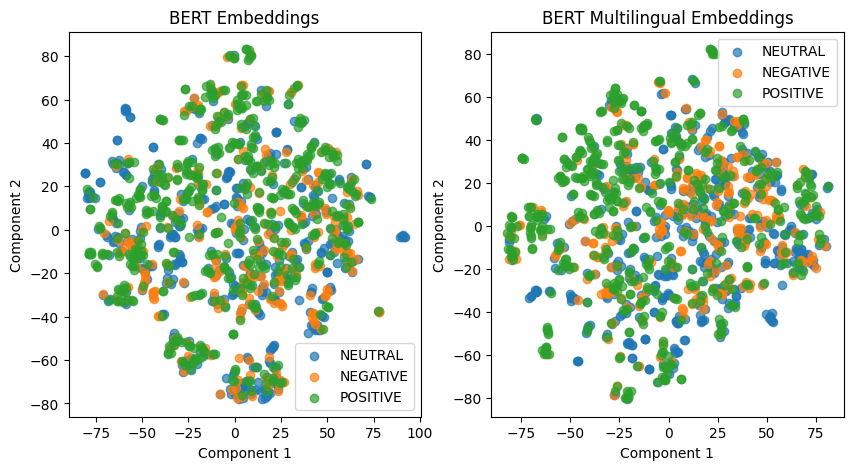

In [5]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

# Perform PCA on the embeddings
embeddings = np.load('bert_embeddings.npy')
embeddings_pt = np.load('bert_pt_embeddings.npy')
pca = TSNE(n_components=2, perplexity=5)
embeddings_pca = pca.fit_transform(embeddings)
pca_pt = TSNE(n_components=2, perplexity=5)
embeddings_pca_pt = pca_pt.fit_transform(embeddings_pt)

# Create a scatter plot
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
for sentiment in df['real_sentiment'].unique():
    indices = df['real_sentiment'] == sentiment
    plt.scatter(embeddings_pca[indices, 0], embeddings_pca[indices, 1], label=sentiment, alpha=0.7)

plt.title("BERT Embeddings")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend()


plt.subplot(1, 2, 2)
for sentiment in df['real_sentiment'].unique():
    indices = df['real_sentiment'] == sentiment
    plt.scatter(embeddings_pca_pt[indices, 0], embeddings_pca_pt[indices, 1], label=sentiment, alpha=0.7)

plt.title("BERT Multilingual Embeddings")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend()
plt.show()


- fazer um classificaodr
- ver a acurácia 
- ver se melhora

In [6]:
df.head()

,post_id,text,created_at,finbertptbr_prediction,gpt_prediction,real_sentiment
0,1818246570069934451,"a partir desse cálculo, para cada empresa do i...",2024-07-30T08:25:38.000000Z,NEUTRAL,NEUTRAL,NEUTRAL
1,1818251106570395982,ibovespa reage às entrelinhas do relatório de ...,2024-07-30T08:43:39.000000Z,NEUTRAL,NEUTRAL,NEUTRAL
2,1818257465793765640,ibovespa em queda de olho na reunião do copom,2024-07-30T09:08:56.000000Z,NEGATIVE,NEGATIVE,NEGATIVE
3,1818262436144669087,esquenta dos mercados \nbom dia!\no ibovespa a...,2024-07-30T09:28:41.000000Z,POSITIVE,NEUTRAL,NEUTRAL
4,1818262819063660642,ibovespa futuro cai na expectativa pelo 1º dia...,2024-07-30T09:30:12.000000Z,NEGATIVE,NEGATIVE,NEGATIVE


In [40]:
tamanho_das_frases = []
for row in df.text:
    print(len(row.split()))
    tamanho_das_frases.append(len(row.split()))

30
22
9
45
10
30
15
17
14
13
24
16
10
24
7
4
10
498
15
36
27
50
17
13
13
12
24
48
12
13
12
36
13
17
9
19
12
15
7
12
12
19
17
36
18
21
11
11
10
7
43
19
101
35
18
11
23
13
10
27
45
9
15
42
13
25
40
12
9
42
22
9
36
19
26
10
12
31
42
10
17
15
10
10
14
14
10
30
47
15
12
10
8
10
12
40
44
18
7
15
37
16
40
7
11
11
53
4
47
15
13
12
17
14
12
32
14
9
27
47
10
13
12
16
39
41
41
10
7
41
19
11
13
10
39
46
13
13
37
13
17
16
22
40
39
18
8
13
13
39
9
28
14
13
8
8
19
10
50
5
18
27
18
5
8
3
89
7
33
46
28
24
11
15
11
23
14
5
45
56
27
10
9
4
44
15
4
17
20
31
10
15
24
7
44
20
51
17
36
22
37
26
17
11
11
17
28
10
14
42
13
36
16
28
14
22
15
21
14
62
37
37
15
25
23
13
37
36
9
12
10
24
49
6
97
40
13
15
14
29
33
14
9
20
40
36
15
26
2
11
45
8
12
21
23
48
14
41
33
15
7
23
8
26
36
42
9
10
14
15
107
36
15
66
5
56
20
15
77
25
39
30
35
48
12
8
10
29
25
17
44
17
8
15
15
14
14
10
32
6
22
8
51
23
28
17
13
11
11
8
23
41
23
17
11
11
31
5
15
36
5
25
16
23
35
3
12
12
35
140
41
15
10
37
51
11
14
24
72
31
12
44
40
10
24
43
11
1

In [41]:
tamanho_das_frases

[30,
 22,
 9,
 45,
 10,
 30,
 15,
 17,
 14,
 13,
 24,
 16,
 10,
 24,
 7,
 4,
 10,
 498,
 15,
 36,
 27,
 50,
 17,
 13,
 13,
 12,
 24,
 48,
 12,
 13,
 12,
 36,
 13,
 17,
 9,
 19,
 12,
 15,
 7,
 12,
 12,
 19,
 17,
 36,
 18,
 21,
 11,
 11,
 10,
 7,
 43,
 19,
 101,
 35,
 18,
 11,
 23,
 13,
 10,
 27,
 45,
 9,
 15,
 42,
 13,
 25,
 40,
 12,
 9,
 42,
 22,
 9,
 36,
 19,
 26,
 10,
 12,
 31,
 42,
 10,
 17,
 15,
 10,
 10,
 14,
 14,
 10,
 30,
 47,
 15,
 12,
 10,
 8,
 10,
 12,
 40,
 44,
 18,
 7,
 15,
 37,
 16,
 40,
 7,
 11,
 11,
 53,
 4,
 47,
 15,
 13,
 12,
 17,
 14,
 12,
 32,
 14,
 9,
 27,
 47,
 10,
 13,
 12,
 16,
 39,
 41,
 41,
 10,
 7,
 41,
 19,
 11,
 13,
 10,
 39,
 46,
 13,
 13,
 37,
 13,
 17,
 16,
 22,
 40,
 39,
 18,
 8,
 13,
 13,
 39,
 9,
 28,
 14,
 13,
 8,
 8,
 19,
 10,
 50,
 5,
 18,
 27,
 18,
 5,
 8,
 3,
 89,
 7,
 33,
 46,
 28,
 24,
 11,
 15,
 11,
 23,
 14,
 5,
 45,
 56,
 27,
 10,
 9,
 4,
 44,
 15,
 4,
 17,
 20,
 31,
 10,
 15,
 24,
 7,
 44,
 20,
 51,
 17,
 36,
 22,
 37,
 26,
 17,
 11,
 11,
 1

In [42]:
df_tamanho = pd.DataFrame(data={"height":tamanho_das_frases})

In [43]:
df_tamanho

,height
0,30
1,22
2,9
3,45
4,10
...,...
1285,5
1286,43
1287,10
1288,10


<Axes: ylabel='Frequency'>

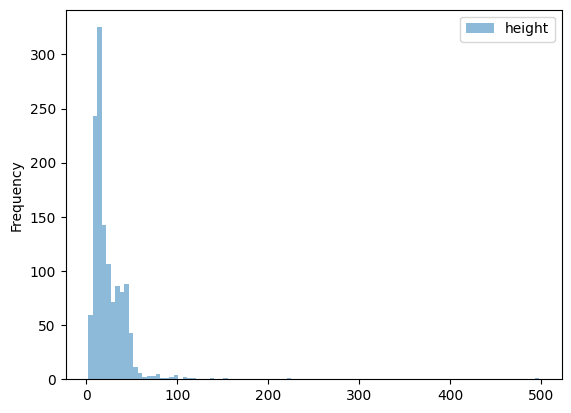

In [44]:
df_tamanho.plot.hist(alpha=0.5,bins=100)